# Building Meter Data Cleaning Notebook
This notebook processes building meter data from Excel files with multiple monthly tabs
and outputs clean CSV data with datetime, power, and site name

## Building Meter Data Cleaning Pipeline
This notebook processes building meter data from Excel files containing multiple tabs of monthly 15-minute interval data.
 
### Input Format:
1. Excel file with multiple sheets (one per month)
2. Each sheet contains columns: ESIID, USAGE_DATE, REVISION_DATE, USAGE_START_TIME, USAGE_END_TIME, USAGE_KWH, ESTIMATED_ACTUAL, CONSUMPTION_GENERATION
3. 15-minute interval data

### Output Format:
1. Clean CSV file with columns: datetime, power_kw, site_name

In [1]:
## 1. Import Required Libraries

# %%
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [8]:
## 2. Configuration

# Define input and output file paths
data_dir = 'data/chapter4/campus-bldg'  # Directory where input files are stored
input_file = os.path.join(data_dir, '2 - J Don Boney Bldg.xlsx')  # Replace with your file path

# Define output file name and path
output_dir = 'data/chapter4/campus-bldg/cleaned'  # Directory where output files will be saved
output_file = os.path.join(output_dir, 'clean_meter_data.csv')     # Output CSV file name

# Extract site name from filename (remove extension)
site_name = os.path.splitext(os.path.basename(input_file))[0].split(' - ')[-1].strip()
print(f"Processing data for site: {site_name}")

Processing data for site: J Don Boney Bldg


## 3. Define Data Processing Functions

In [35]:
def combine_date_time(date_val, time_val):
    """
    Combine date and time values from Excel into a proper datetime.
    
    Args:
        date_val: Date value from USAGE_DATE column
        time_val: Time value from USAGE_START_TIME or USAGE_END_TIME column
    
    Returns:
        Combined datetime object
    """
    try:
        # Parse the date and return strptime object
        if pd.isna(date_val) or pd.isna(time_val):
            return pd.NaT
        
        if isinstance(date_val, str):
            date_part = pd.to_datetime(date_val).strftime('%Y-%m-%d')
        elif isinstance(date_val, datetime):
            # If date_val is already a datetime object, convert it to string
            date_part = date_val.strftime('%Y-%m-%d')
        else:
            # If date_val is not a string or datetime, convert it to string
            date_part = str(date_val)

        if isinstance(time_val, str):
            # Handle time values that might be in HH:MM format
            time_val = time_val.strip()
            if len(time_val) == 5 and time_val[2] == ':':
                time_val += ' AM'
            time_val = pd.to_datetime(time_val, format='%I:%M %p', errors='coerce').strftime('%H:%M:%S')
        elif isinstance(time_val, datetime):
            # If time_val is already a datetime object, convert it to string
            time_val = time_val.strftime('%H:%M:%S')
        else:
            # If time_val is not a string or datetime, convert it to string
            time_val = str(time_val)
        
        # Combine date and time using datetime.combine instead of pd.Timestamp.combine
        return pd.to_datetime(date_part + ' ' + time_val, errors='coerce')

    except Exception as e:
        # Print Exception if any error occurs
        print(f"Error combining date and time: {e}")
        return pd.NaT

In [36]:
def process_sheet(df, sheet_name):
    """
    Process a single sheet of meter data.
    
    Args:
        df: DataFrame containing the sheet data
        sheet_name: Name of the sheet (used for debugging)
    
    Returns:
        Cleaned DataFrame with datetime and power columns
    """
    print(f"\nProcessing sheet: {sheet_name}")
    print(f"  Original shape: {df.shape}")
    
    # Check if the dataframe has the expected columns
    expected_cols = ['ESIID', 'USAGE_DATE', 'USAGE_START_TIME', 'USAGE_END_TIME', 'USAGE_KWH']
    
    # If columns are not named, assign them based on position
    if df.columns[0] != 'ESIID':
        # Assume first row contains headers
        df.columns = df.iloc[0]
        df = df[1:].reset_index(drop=True)
    
    # Check for required columns
    missing_cols = [col for col in expected_cols if col not in df.columns]
    if missing_cols:
        print(f"  Warning: Missing columns {missing_cols}")
        return pd.DataFrame()
    
    # Create a copy for processing
    processed_df = df[expected_cols].copy()
    
    # Convert USAGE_KWH to numeric
    processed_df['USAGE_KWH'] = pd.to_numeric(processed_df['USAGE_KWH'], errors='coerce')

    # Combine date and start time to create datetime
    processed_df['datetime'] = processed_df.apply(
        lambda row: combine_date_time(row['USAGE_DATE'], row['USAGE_START_TIME']), 
        axis=1
    )
    # processed_df['datetime'] = processed_df.apply(
    #     lambda row: str(row['USAGE_DATE']) + ' ' + str(row['USAGE_START_TIME']), 
    #     axis=1
    # )
    # Remove rows with invalid datetime
    processed_df = processed_df.dropna(subset=['datetime'])
    
    # Convert kWh to kW (for 15-minute intervals, multiply by 4)
    # Since we have energy consumption for 15-minute intervals,
    # power = energy * 4 (to convert from kWh per 15 min to kW)
    processed_df['power_kw'] = processed_df['USAGE_KWH'] * 4
    
    # Select and rename columns
    result_df = processed_df[['datetime', 'power_kw']].copy()
    
    # Sort by datetime
    result_df = result_df.sort_values('datetime')
    
    print(f"  Processed shape: {result_df.shape}")
    print(f"  Date range: {result_df['datetime'].min()} to {result_df['datetime'].max()}")
    print(f"  Power range: {result_df['power_kw'].min():.2f} to {result_df['power_kw'].max():.2f} kW")
    
    return result_df

## 4. Load and Process Excel File


In [37]:
# Read all sheets from the Excel file
print(f"Reading Excel file: {input_file}")
excel_file = pd.ExcelFile(input_file)
print(f"Found {len(excel_file.sheet_names)} sheets: {excel_file.sheet_names}")

# Process each sheet and combine the results
all_data = []

for sheet_name in excel_file.sheet_names:
    # Read the sheet
    df = pd.read_excel(input_file, sheet_name=sheet_name)

    # Process the sheet
    processed_df = process_sheet(df, sheet_name)
    
    if not processed_df.empty:
        all_data.append(processed_df)

# Combine all processed data
if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"\nCombined data shape: {combined_df.shape}")
else:
    print("No data was processed successfully!")
    combined_df = pd.DataFrame()

Reading Excel file: data/chapter4/campus-bldg/2 - J Don Boney Bldg.xlsx
Found 12 sheets: ['April - 2020', 'March - 2020', 'Feb - 2020', 'Jan - 2020', 'Dec - 2019', 'Nov- 2019', 'Oct- 2019', 'Sept - 2019', 'Aug - 2019', 'July - 2019', 'June - 2019', 'May - 2019']

Processing sheet: April - 2020
  Original shape: (2880, 8)
  Processed shape: (2880, 2)
  Date range: 2020-04-01 00:00:00 to 2020-04-30 23:45:00
  Power range: 25.88 to 64.51 kW

Processing sheet: March - 2020
  Original shape: (2976, 8)
  Processed shape: (2976, 2)
  Date range: 2020-03-01 00:00:00 to 2020-03-31 23:45:00
  Power range: 28.80 to 124.34 kW

Processing sheet: Feb - 2020
  Original shape: (2784, 8)
  Processed shape: (2784, 2)
  Date range: 2020-02-01 00:00:00 to 2020-02-29 23:45:00
  Power range: 36.86 to 93.24 kW

Processing sheet: Jan - 2020
  Original shape: (2976, 8)
  Processed shape: (2976, 2)
  Date range: 2020-01-01 00:00:00 to 2020-01-31 23:45:00
  Power range: 22.20 to 81.72 kW

Processing sheet: Dec -

In [39]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35140 entries, 0 to 35139
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  35140 non-null  datetime64[ns]
 1   power_kw  35136 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 549.2 KB


## 5. Clean and Prepare Final Dataset

In [40]:
if not combined_df.empty:
    # Remove duplicates based on datetime
    initial_count = len(combined_df)
    combined_df = combined_df.drop_duplicates(subset=['datetime'])
    duplicates_removed = initial_count - len(combined_df)
    print(f"Removed {duplicates_removed} duplicate timestamps")
    
    # Sort by datetime
    combined_df = combined_df.sort_values('datetime')
    
    # Add site name column
    combined_df['site_name'] = site_name
    
    # Reorder columns
    final_df = combined_df[['datetime', 'power_kw', 'site_name']]
    
    # Reset index
    final_df = final_df.reset_index(drop=True)
    
    print(f"\nFinal dataset shape: {final_df.shape}")
    print(f"Date range: {final_df['datetime'].min()} to {final_df['datetime'].max()}")
    print(f"Total time span: {(final_df['datetime'].max() - final_df['datetime'].min()).days} days")
else:
    final_df = pd.DataFrame(columns=['datetime', 'power_kw', 'site_name'])
    print("No data to process!")

Removed 4 duplicate timestamps

Final dataset shape: (35136, 3)
Date range: 2019-05-01 00:00:00 to 2020-04-30 23:45:00
Total time span: 365 days


## 6. Visualize the Data

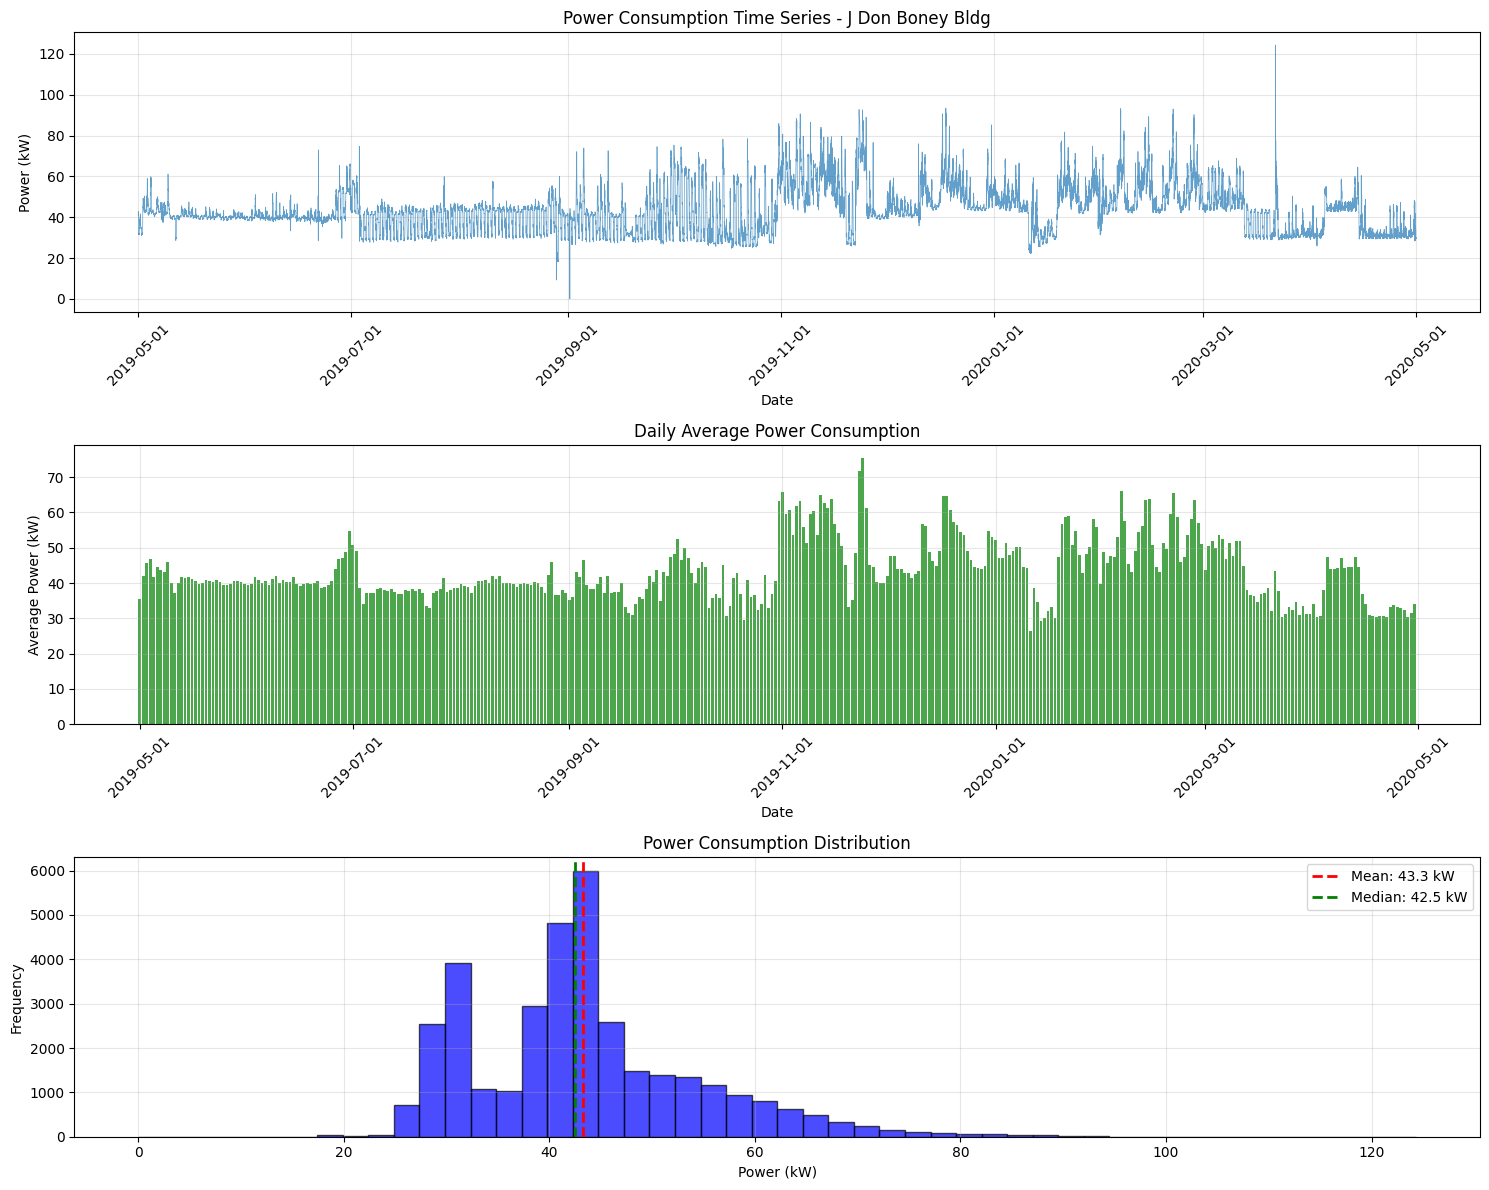

In [41]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# 1. Time series plot
ax1 = axes[0]
ax1.plot(final_df['datetime'], final_df['power_kw'], linewidth=0.5, alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('Power (kW)')
ax1.set_title(f'Power Consumption Time Series - {SITE_NAME}')
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# 2. Daily average plot
ax2 = axes[1]
daily_avg = final_df.set_index('datetime').resample('D')['power_kw'].mean()
ax2.bar(daily_avg.index, daily_avg.values, width=0.8, alpha=0.7, color='green')
ax2.set_xlabel('Date')
ax2.set_ylabel('Average Power (kW)')
ax2.set_title('Daily Average Power Consumption')
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# 3. Distribution plot
ax3 = axes[2]
ax3.hist(final_df['power_kw'], bins=50, edgecolor='black', alpha=0.7, color='blue')
ax3.set_xlabel('Power (kW)')
ax3.set_ylabel('Frequency')
ax3.set_title('Power Consumption Distribution')
ax3.grid(True, alpha=0.3)

# Add mean and median lines
mean_val = final_df['power_kw'].mean()
median_val = final_df['power_kw'].median()
ax3.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f} kW')
ax3.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f} kW')
ax3.legend()

plt.tight_layout()
plt.show()

## 8. Save Cleaned Data to CSV

In [43]:
if not final_df.empty:
    # Save to CSV
    final_df.to_csv(output_file, index=False)
    print(f"✅ Data saved to: {output_file}")
    print(f"   Total records: {len(final_df):,}")
    print(f"   Columns: {list(final_df.columns)}")
    
    # Display first and last few rows
    print("\nFirst 5 records:")
    print(final_df.head())
    
    print("\nLast 5 records:")
    print(final_df.tail())
else:
    print("❌ No data to save!")

✅ Data saved to: data/chapter4/campus-bldg/cleaned/clean_meter_data.csv
   Total records: 35,136
   Columns: ['datetime', 'power_kw', 'site_name']

First 5 records:
             datetime  power_kw         site_name
0 2019-05-01 00:00:00    40.856  J Don Boney Bldg
1 2019-05-01 00:15:00    42.392  J Don Boney Bldg
2 2019-05-01 00:30:00    42.776  J Don Boney Bldg
3 2019-05-01 00:45:00    41.472  J Don Boney Bldg
4 2019-05-01 01:00:00    39.552  J Don Boney Bldg

Last 5 records:
                 datetime  power_kw         site_name
35131 2020-04-30 22:45:00    30.184  J Don Boney Bldg
35132 2020-04-30 23:00:00    29.568  J Don Boney Bldg
35133 2020-04-30 23:15:00    29.720  J Don Boney Bldg
35134 2020-04-30 23:30:00    29.416  J Don Boney Bldg
35135 2020-04-30 23:45:00    29.492  J Don Boney Bldg


## Optional: Detect anomilies

In [44]:
def detect_anomalies(df, threshold_std=3):
    """
    Detect anomalies using statistical methods.
    
    Args:
        df: DataFrame with power_kw column
        threshold_std: Number of standard deviations for anomaly detection
    
    Returns:
        DataFrame with anomaly flag column
    """
    if df.empty:
        return df
    
    df = df.copy()
    
    # Calculate rolling statistics
    window = 96  # 24 hours for 15-min data
    df['rolling_mean'] = df['power_kw'].rolling(window=window, center=True).mean()
    df['rolling_std'] = df['power_kw'].rolling(window=window, center=True).std()
    
    # Flag anomalies
    df['is_anomaly'] = abs(df['power_kw'] - df['rolling_mean']) > (threshold_std * df['rolling_std'])
    
    # Count anomalies
    anomaly_count = df['is_anomaly'].sum()
    print(f"Anomalies detected: {anomaly_count} ({anomaly_count/len(df)*100:.2f}%)")
    
    return df

# Optional to use:
final_df_with_anomalies = detect_anomalies(final_df)

Anomalies detected: 125 (0.36%)
